# Building polygonization

In [1]:
import argparse
import os

import fiona
import numpy as np
import rasterio
import rasterio.crs
import rasterio.features
import rasterio.mask
import rasterio.plot
import rasterio.warp
import shapely
import shapely.geometry
import utm
from scipy.optimize import minimize
from tqdm import tqdm

import seaborn as sns

In [2]:
# Import functions
%run inference-functions.ipynb import visualize_tile_predvOSM, get_bounds

In [3]:
def get_utm_zone_from_lat_lon(lat, lon):
    """Calculates the UTM CRS for a given lat lon (EPSG:4326) point

    Returns:
        a rasterio CRS object
    """
    projection_dict = {"proj": "utm", "zone": utm.latlon_to_zone_number(lat, lon)}
    if lat < 0:
        projection_dict["south"] = True
    # NOTE: Hardcoded as the below didn't work due to environment issues with fiona and rasterio
    return rasterio.crs.CRS.from_dict(init='epsg:26910')
    #return rasterio.crs.CRS.from_dict(projection_dict)


def get_azimuth(pt1, pt2):
    a = np.arctan2(pt1[0] - pt2[0], pt1[1] - pt2[1])
    return np.degrees(a) if a >= 0 else np.degrees(a) + 360


def get_angle(pt1, pt2, pt3):
    a1 = get_azimuth(pt1, pt2)
    a2 = get_azimuth(pt3, pt2)
    angle = a2 - a1
    return angle if angle > 0 else angle + 360


def angle_loss(angles_in_degrees, dcoords):
    val = 0
    for r in np.radians(angles_in_degrees):
        val += -np.cos(r * 4) + 1
    val += np.linalg.norm(dcoords, ord=2)
    return val


def get_loss_function(shape):
    coords = np.array(list(shape.exterior.coords)[:-1])

    def loss(dcoords):
        dcoords = dcoords.reshape(-1, 2)
        new_coords = coords + dcoords
        angles = []
        for i in range(-2, coords.shape[0] - 2):
            angles.append(
                get_angle(new_coords[i], new_coords[i + 1], new_coords[i + 2])
            )
        val = angle_loss(angles, dcoords)
        return val

    return loss, coords


def optimize(shape, tolerance=0.5, maxiter=50):
    shape = shape.simplify(tolerance)

    loss_fn, coords = get_loss_function(shape)
    result = minimize(
        loss_fn, np.zeros_like(coords).ravel(), options={"maxiter": maxiter}
    )
    dcoords = result.x.reshape(-1, 2)
    shape = shapely.geometry.Polygon(shell=coords + dcoords)
    shape = shape.simplify(tolerance)

    return shape


def set_up_parser():
    """Set up the argument parser.

    Returns:
        the argument parser
    """
    parser = argparse.ArgumentParser(
        description=__doc__, formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )
    parser.add_argument(
        "-e",
        "--epsilon",
        default=0.5,
        type=float,
        help="epsilon value used in Douglas-Peucker simplification",
    )
    parser.add_argument(
        "--input_fn",
        type=str,
        required=True,
        help="input mask filename (must be a GeoTIFF where the value of '1' indicates a predicted building)",
    )
    parser.add_argument(
        "--output_fn",
        type=str,
        required=True,
        help="output filename (must be a gpkg)",
    )
    parser.add_argument(
        "-v", "--verbose", action="store_true", help="print results to stdout"
    )

    return parser


def main(args):

    assert args.input_fn.lower().endswith(".tif")
    assert os.path.exists(args.input_fn)
    assert args.output_fn.lower().endswith(".gpkg")
    assert not os.path.exists(args.output_fn)

    with rasterio.open(args.input_fn) as f:
        src_crs = f.crs
        #print(src_crs)
        dst_crs = get_utm_zone_from_lat_lon(f.bounds.top, f.bounds.left)
        #print(dst_crs)
        features = list(
            rasterio.features.dataset_features(
                f,
                bidx=1,
                sampling=1,
                band=True,
                as_mask=False,
                with_nodata=False,
                geographic=False,
                precision=-1,
            )
        )

    shapes = []
    for feature in features:
        if feature["properties"]["val"] == 1:
            geom = rasterio.warp.transform_geom(src_crs, dst_crs, feature["geometry"])
            shapes.append(shapely.geometry.shape(geom))
    
    schema = {"geometry": "Polygon", "properties": {"id": "int"}}

    with fiona.open(
        #args.output_fn, "w", driver="GPKG", crs="EPSG:4326", schema=schema 
        args.output_fn, "w", driver="GPKG", crs="EPSG:26910", schema=schema #NOTE: changed from above to match our CRS
    ) as f:
        for i, shape in enumerate(tqdm(shapes)):
            shape = shape.simplify(args.epsilon)

            new_shape = optimize(shape, args.epsilon)

            geom = shapely.geometry.mapping(new_shape)
            geom = rasterio.warp.transform_geom(dst_crs, src_crs, geom)
            row = {"type": "Feature", "geometry": geom, "properties": {"id": i}}
            f.write(row)

In [4]:
def run_tile(epsilon, input_fn, output_fn, verbose):
    parser = set_up_parser()
    argString = '-e {} --input_fn {} --output_fn {}'.format(epsilon, input_fn, output_fn)
    if verbose:
        argString += ' -v'
    args = parser.parse_args(args=argString.split())
    main(args)

In [5]:
def save_raster(template_file, out_file, infer_tile):
    # Note: code adapted from https://mhweber.github.io/2016/12/12/rasterize-shapefiles-in-python-with-rasterio-and-geopandas/
    with rasterio.open(template_file) as template:
        kwargs = template.meta.copy()
        kwargs.update({
            'driver': 'GTiff',
            'compress': 'lzw'}) 

        with rasterio.open(out_file, 'w+', **kwargs) as dst:
            out_arr = template.read(1)
            out_arr = np.zeros_like(out_arr)
            # this is where we create a generator of geom, value pairs to use in rasterizing
            shapes = (geom for geom in infer_tile.to_crs('EPSG:26910').geometry)

            burned = rasterio.features.rasterize(
                shapes=shapes, fill=0, out=out_arr, transform=template.transform, default_value=1)
            dst.write(burned, 1)

In [37]:
def plot_exteriors(file_name, infer_tile, osm_tile, poly_tile, tile_img, epsilon, save=False):
    # Get raster for plotting purposes
    raster = rasterio.open(os.path.join(TIF_FP, '{}.tif'.format(file_name)))
    t = from_bounds(*raster.bounds, tile_img.shape[0], tile_img.shape[1])

    # Get shape boundaries
    infer_tile_ext = infer_tile.copy()
    infer_tile_ext.geometry = infer_tile_ext.geometry.exterior

    osm_tile_ext = osm_tile.copy()
    osm_tile_ext.geometry = osm_tile_ext.geometry.exterior
    
    poly_tile_ext = poly_tile.copy()
    poly_tile_ext.geometry = poly_tile_ext.geometry.exterior

    # Plot inference vs OSM
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16))
    rasterio.plot.show(np.moveaxis(tile_img, 2, 0),transform=t, ax=ax1)
    rasterio.plot.show(np.moveaxis(tile_img, 2, 0),transform=t, ax=ax2)
    
    if len(osm_tile_ext) > 0:
        osm_tile_ext.to_crs('EPSG:26910').plot(ax=ax1, alpha=0.8, color='blue')
    if len(infer_tile_ext) > 0:
        infer_tile_ext.to_crs('EPSG:26910').plot(ax=ax1, alpha=1, color='red')
    ax1.axis('off')
    
    if len(osm_tile_ext) > 0:
        osm_tile_ext.to_crs('EPSG:26910').plot(ax=ax2, alpha=0.8, color='blue')
    if len(poly_tile_ext) > 0:
        poly_tile_ext.plot(ax=ax2, alpha=1, color='red')
    ax2.axis('off')
    if save:
        plt.savefig(os.path.join(OUTPUT_FP_POLY, 'viz-{}-{}.png'.format(file_name, epsilon)), bbox_inches='tight')
    else:
        plt.show()
    plt.close(fig)

In [33]:
def polygonize_tile(tile_name, verbose=True, epsilon=0.5):
    tile_bounds = get_bounds(tile_bounds_dict, tile_name)
    
    # Get tile image
    img_file = None
    for dirname in ['train', 'val', 'test']:
        dirpath = os.path.join(IMG_FP, dirname, 'images', '{}.npy'.format(tile_name))
        if os.path.exists(dirpath):
            img_file = dirpath
    tile_img = np.load(img_file)

    # Load inference and OSM
    infer_tile = gpd.clip(building_footprints_infer, tile_bounds)
    osm_tile = gpd.clip(building_footprints_osm, tile_bounds)

    # Generate tif
    template_file = os.path.join(TIF_FP, '{}.tif'.format(tile_name))
    out_file = os.path.join(OUTPUT_FP_POLY, '{}-infer.tif'.format(tile_name))
    poly_file = os.path.join(OUTPUT_FP_POLY, '{}-poly-{}.gpkg'.format(tile_name, epsilon))
    if len(infer_tile) > 0:
        if not os.path.exists(out_file):
            save_raster(template_file, out_file, infer_tile)
    
        # Polygonize
        if not os.path.exists(poly_file):
            run_tile(epsilon=epsilon, input_fn=out_file, output_fn=poly_file, verbose=verbose)

        poly_tile = gpd.read_file(poly_file)
    else:
        poly_tile = gpd.GeoDataFrame(geometry=[])
    return infer_tile, osm_tile, poly_tile, tile_img

## 

In [8]:
# Paths
SHAPEFILE_FP = '/oak/stanford/groups/deho/building_compliance/shapefiles'
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
TIF_FP = '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/raw_tif'
INFERENCES_DIR = '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/phase2_superresx2/infer/'
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-2020')
OUTPUT_FP_POLY = os.path.join(OUTPUT_FP, 'Building-Polygonization')
IMG_FP = os.path.join(OAK_FP, 'san_jose_naip_512', 'phase2_superresx2')

In [9]:
# Load tile dict for each year
with open(os.path.join(OUTPUT_FP, 'tile_bounds.json'), "r") as f:
    tile_bounds_dict = json.load(f)

# Load OSM and current predictions
building_footprints_osm = gpd.read_file(os.path.join(OAK_FP, 'outputs/cbg-inference-2020/osm_building_processed'))
building_footprints_infer = gpd.read_file(os.path.join(OAK_FP, 'outputs/cbg-inference-2020/inference_building_processed'))

<Figure size 640x480 with 0 Axes>

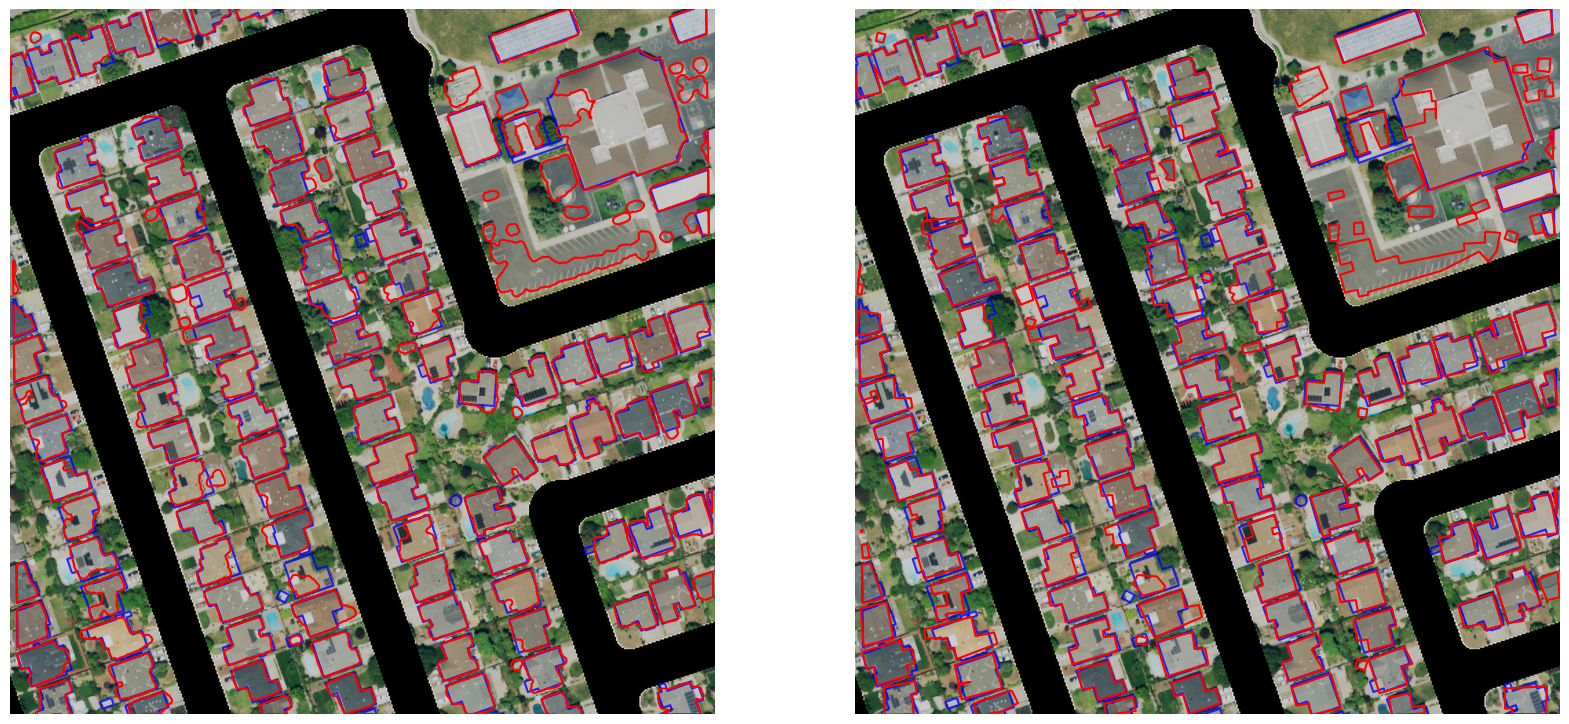

In [38]:
# Test on given tile
tile_name = 'm_3712142_nw_10_060_20200525_44'
tile_name = 'm_3712141_sw_10_060_20200525_99'
#tile_name = 'm_3712142_ne_10_060_20200525_383'
#tile_name = 'm_3712142_sw_10_060_20200525_320'
tile_name = 'm_3712149_ne_10_060_20200525_15'
infer_tile, osm_tile, poly_tile, tile_img = polygonize_tile(tile_name=tile_name, verbose=True, epsilon=0.9)
plot_exteriors(file_name=tile_name, infer_tile=infer_tile, osm_tile=osm_tile, poly_tile=poly_tile, epsilon=0.9, tile_img=tile_img)


<Figure size 640x480 with 0 Axes>

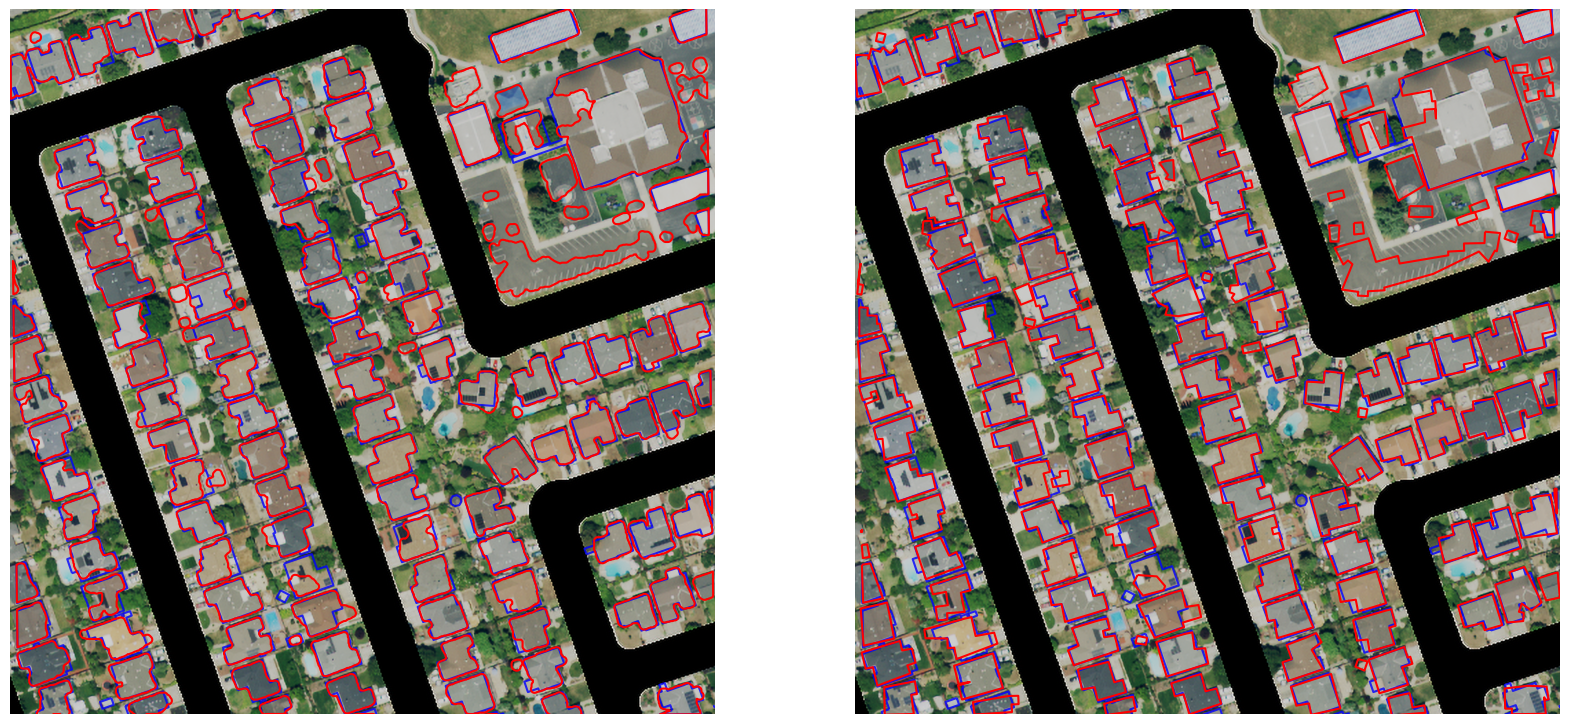

In [39]:
infer_tile, osm_tile, poly_tile, tile_img = polygonize_tile(tile_name=tile_name, verbose=True, epsilon=0.8)
plot_exteriors(
    file_name=tile_name, infer_tile=infer_tile,
    osm_tile=osm_tile, poly_tile=poly_tile, tile_img=tile_img, epsilon=0.8)

<Figure size 640x480 with 0 Axes>

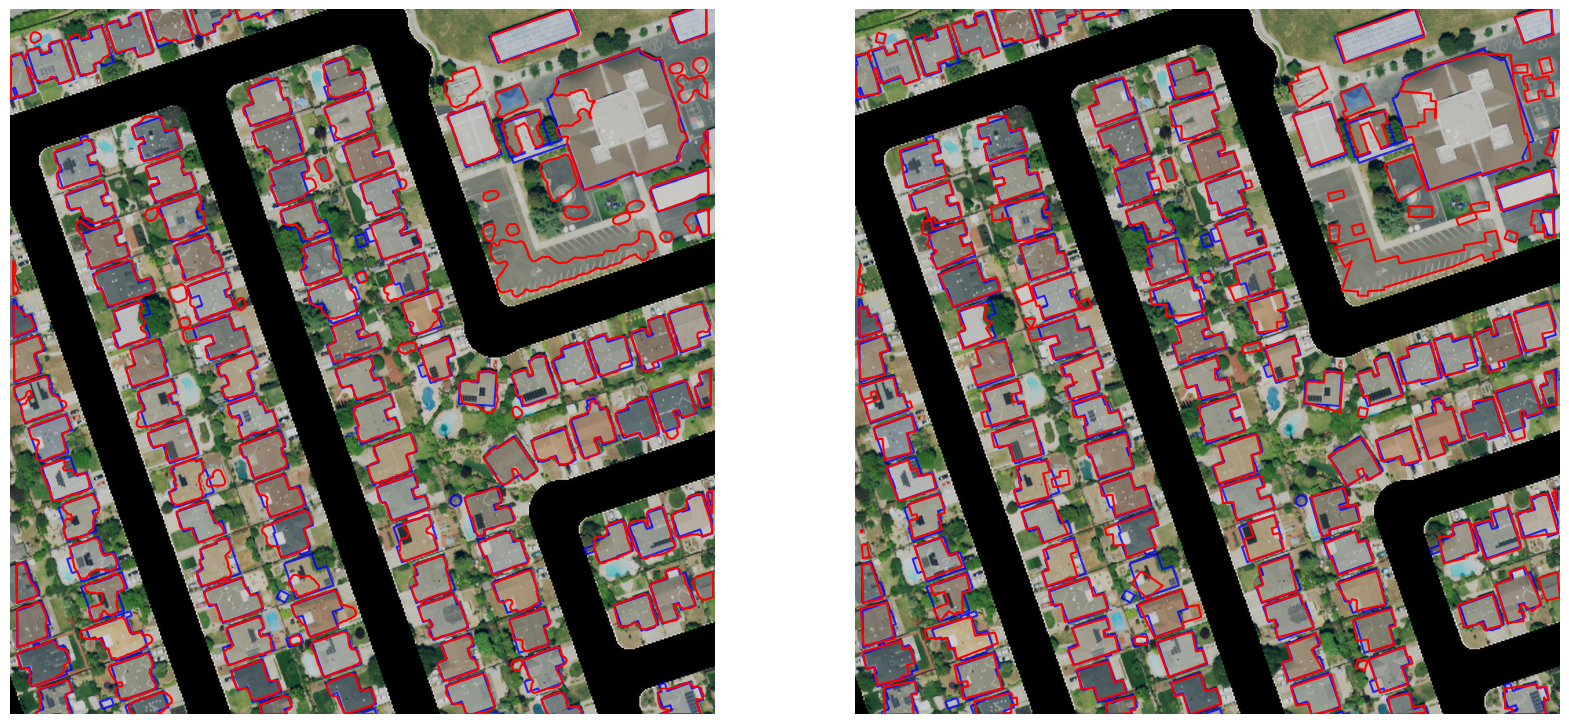

In [40]:
infer_tile, osm_tile, poly_tile, tile_img = polygonize_tile(tile_name=tile_name, verbose=True, epsilon=0.7)
plot_exteriors(
    file_name=tile_name, infer_tile=infer_tile,
    osm_tile=osm_tile, poly_tile=poly_tile, tile_img=tile_img, epsilon=0.7)

<Figure size 640x480 with 0 Axes>

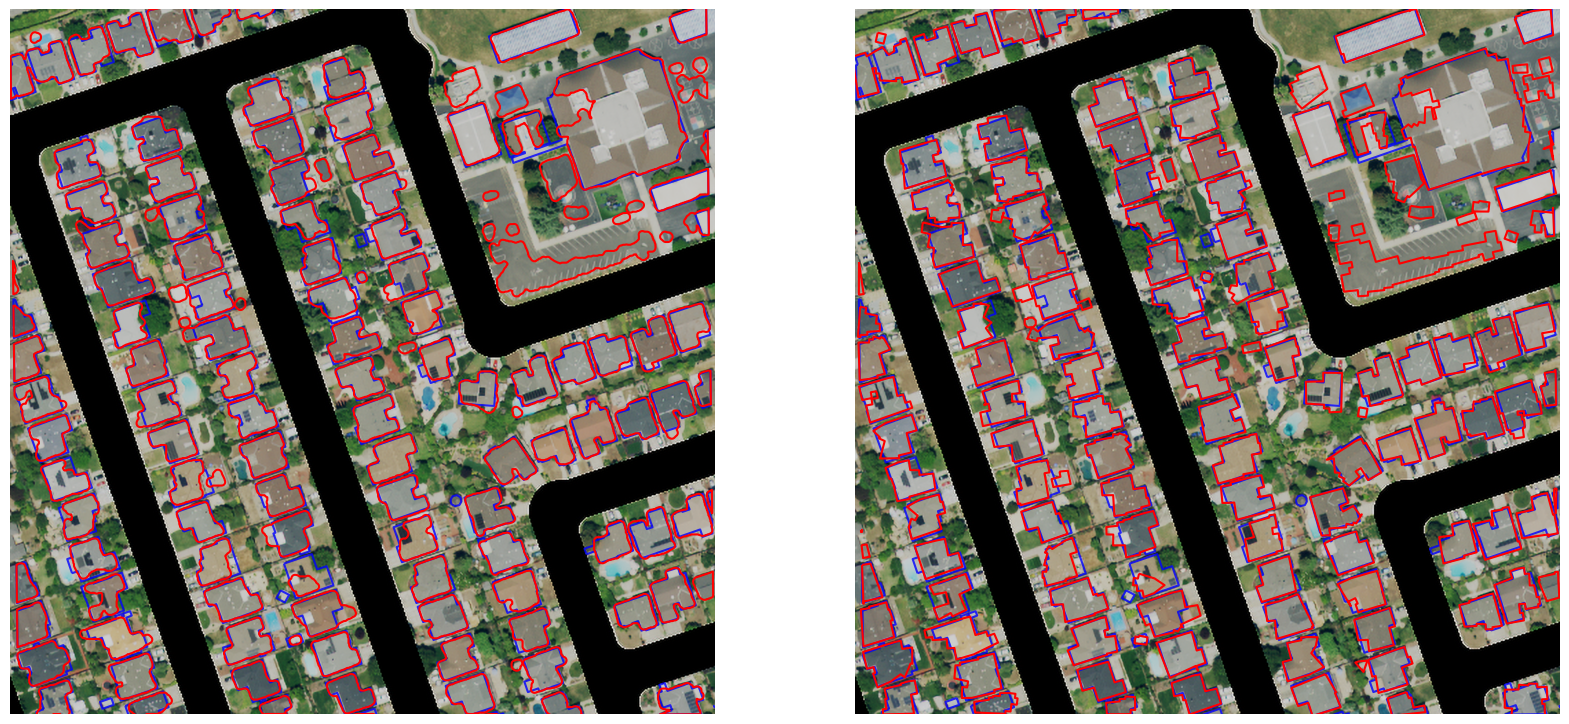

In [41]:
infer_tile, osm_tile, poly_tile, tile_img = polygonize_tile(tile_name=tile_name, verbose=True, epsilon=0.5)
plot_exteriors(
    file_name=tile_name, infer_tile=infer_tile,
    osm_tile=osm_tile, poly_tile=poly_tile, tile_img=tile_img, epsilon=0.5)

<Figure size 640x480 with 0 Axes>

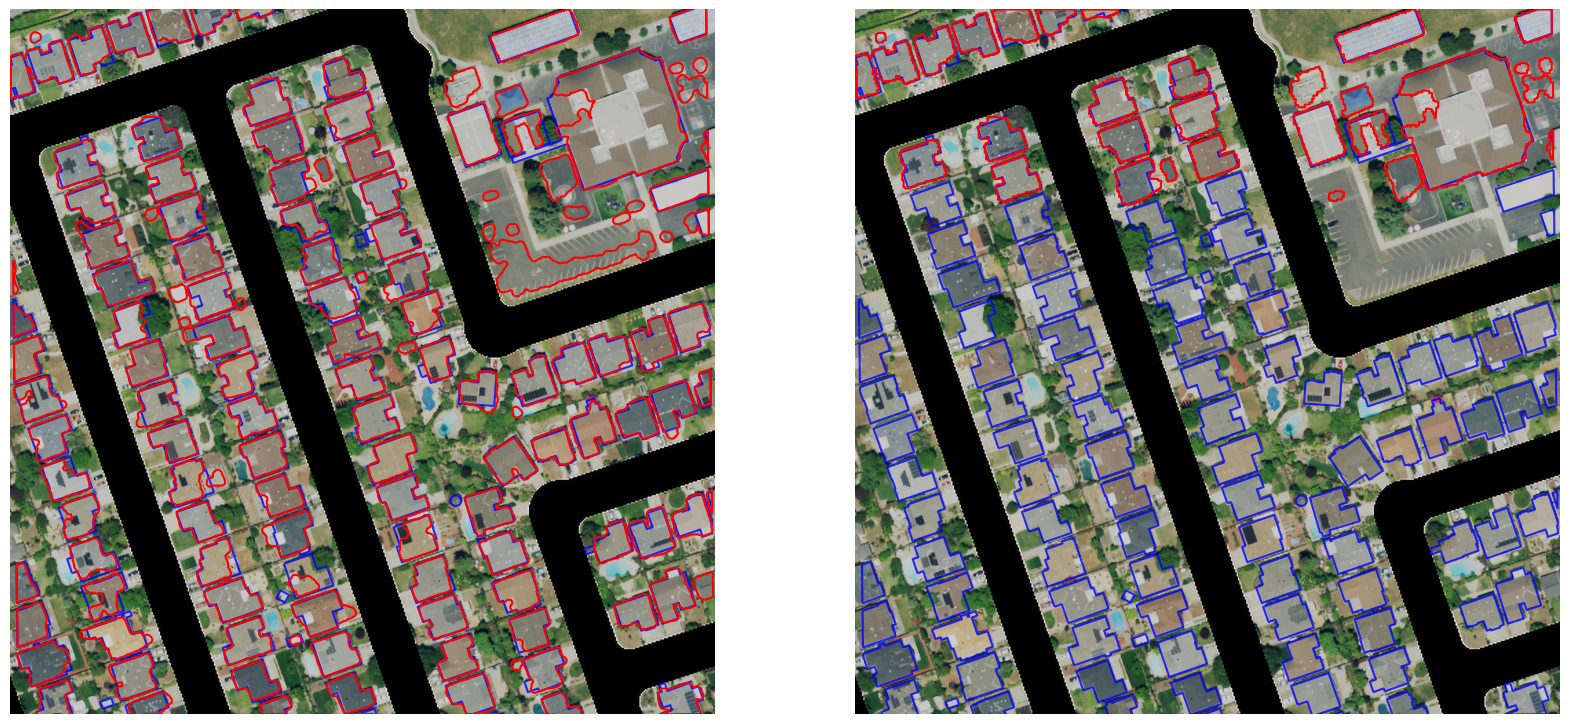

In [42]:
infer_tile, osm_tile, poly_tile, tile_img = polygonize_tile(tile_name=tile_name, verbose=True, epsilon=0.3)
plot_exteriors(
    file_name=tile_name, infer_tile=infer_tile,
    osm_tile=osm_tile, poly_tile=poly_tile, tile_img=tile_img, epsilon=0.3)

Randomly sample tiles

In [29]:
RANDOM_TILE_SIZE = 50
np.random.seed(42)
random_tile_names = np.random.choice(list(tile_bounds_dict.keys()), size=RANDOM_TILE_SIZE, replace=False)

# To use the tiles we've already polygonized
np.random.seed(42)
extended_list = list(np.random.choice(list(tile_bounds_dict.keys()), size=150, replace=False))
random_tile_names = list(random_tile_names) + extended_list[:50]

In [34]:
epsilon_values = [0.5, 0.7, 0.8, 0.9]

infer_tile_dict = {}
osm_tile_dict = {}
poly_tile_dict = {}

for epsilon in epsilon_values:
    print('[INFO] Epsilon: {}'.format(epsilon))
    infer_tile_all = gpd.GeoDataFrame()
    osm_tile_all = gpd.GeoDataFrame()
    poly_tile_all = gpd.GeoDataFrame()

    for tile_name in tqdm(random_tile_names):
        infer_tile, osm_tile, poly_tile, tile_img = polygonize_tile(
            tile_name=tile_name, verbose=False, epsilon=epsilon)

        # Add tile name
        infer_tile['tile_name'] = tile_name
        osm_tile['tile_name'] = tile_name
        poly_tile['tile_name'] = tile_name

        if len(poly_tile) > 0: # Issues with rasterio not recognizing some tiles
            infer_tile_all = pd.concat([infer_tile_all, infer_tile])
            osm_tile_all = pd.concat([osm_tile_all, osm_tile])
            poly_tile_all = pd.concat([poly_tile_all, poly_tile.to_crs('EPSG:4326')])

            # Visualize
            if not os.path.exists(os.path.join(OUTPUT_FP_POLY, 'viz-{}-{}.png'.format(tile_name, epsilon))):
                plot_exteriors(
                    file_name=tile_name, infer_tile=infer_tile, osm_tile=osm_tile, 
                    poly_tile=poly_tile, tile_img=tile_img, save=True, epsilon=epsilon)
    infer_tile_dict[str(epsilon)] = infer_tile_all
    osm_tile_dict[str(epsilon)] = osm_tile_all
    poly_tile_dict[str(epsilon)] = poly_tile_all

[INFO] Epsilon: 0.5


100%|██████████| 100/100 [1:03:36<00:00, 38.17s/it]


[INFO] Epsilon: 0.7


100%|██████████| 100/100 [1:00:51<00:00, 36.51s/it]


[INFO] Epsilon: 0.8


100%|██████████| 100/100 [1:04:32<00:00, 38.72s/it]


[INFO] Epsilon: 0.9


100%|██████████| 100/100 [1:07:04<00:00, 40.24s/it]


Epsilon: 0.5
39


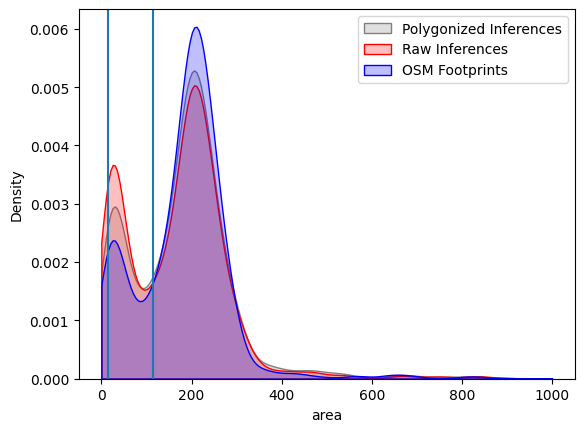

Epsilon: 0.7
39


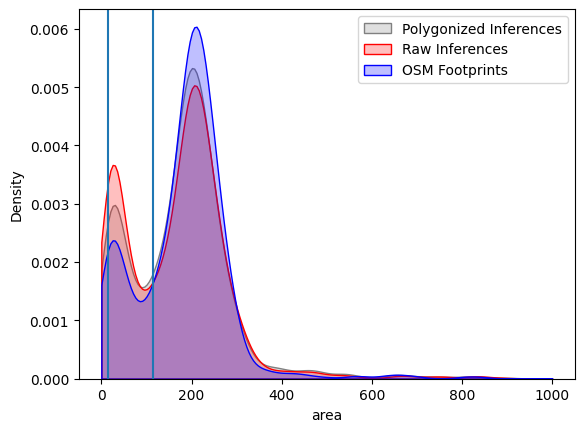

Epsilon: 0.8
39


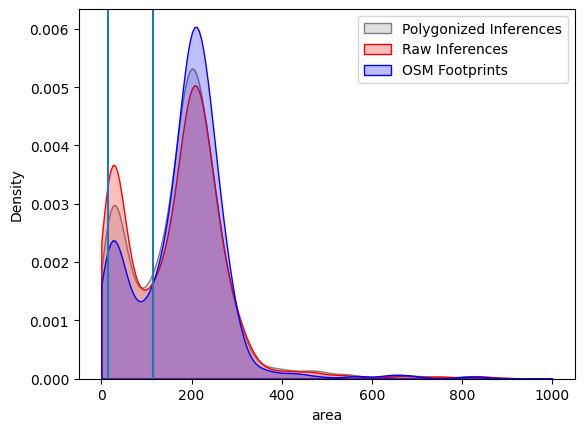

Epsilon: 0.9
39


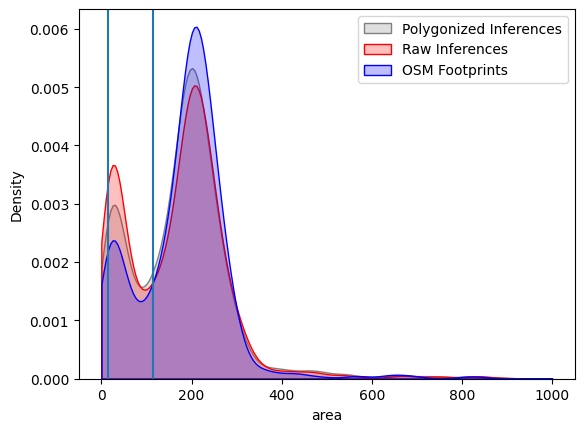

In [44]:
# 1. Distribution areas
tile_all_dict = {}
for epsilon in epsilon_values:
    print('Epsilon: {}'.format(epsilon))
    infer_tile_all, osm_tile_all, poly_tile_all = infer_tile_dict[str(epsilon)], osm_tile_dict[str(epsilon)], poly_tile_dict[str(epsilon)]
    print(len(infer_tile_all['tile_name'].unique()))
    tile_all = gpd.GeoDataFrame()
                                                                                                                             
    for gdf, name in zip([infer_tile_all, osm_tile_all, poly_tile_all], ['infer', 'osm', 'poly']):
        gdf['gdf_type'] = name
        tile_all = pd.concat([tile_all, gdf])

    tile_all = tile_all.to_crs('EPSG:26910')
    tile_all['area'] = tile_all.area
    tile_all = tile_all.to_crs('EPSG:4326')

    tile_all.drop(inplace=True, columns=['index_left', 'index', 'id', 'small', 'large', 'GEOID'], axis=1)
    tile_all.reset_index(inplace=True)
    tile_all_dict[str(epsilon)] = tile_all

    # Plot
    g=tile_all.groupby('gdf_type')
    fig, ax = plt.subplots()

    ax = sns.kdeplot(data=g.get_group('poly')['area'], label='Polygonized Inferences', ax=ax, shade=True, clip=(0, 1000), color='gray')
    ax = sns.kdeplot(data=g.get_group('infer')['area'], label='Raw Inferences', ax=ax, shade=True, clip=(0, 1000), color='red')
    ax = sns.kdeplot(data=g.get_group('osm')['area'], label='OSM Footprints', ax=ax, shade=True, clip=(0, 1000), color='blue')
    plt.axvline(15)
    plt.axvline(115)
    plt.legend()
    plt.show()

In [36]:
# Gdf of tiles
tile_metrics_pd = pd.DataFrame(random_tile_names, columns=['file'])
tile_metrics_pd['geometry'] = tile_metrics_pd.file.progress_apply(
    lambda name: get_bounds(tile_bounds_dict, name) if name in list(tile_bounds_dict.keys()) else None
)
tiles_gdf = gpd.GeoDataFrame(tile_metrics_pd.copy(), crs='EPSG:4326')

100%|██████████| 100/100 [00:00<00:00, 5618.02it/s]


Epsilon: 0.5
count    39.000000
mean      0.739984
std       0.148413
min       0.171594
25%       0.721789
50%       0.774017
75%       0.804528
max       0.922504
Name: IoU, dtype: float64
count    39.000000
mean      0.708475
std       0.144223
min       0.162853
25%       0.686168
50%       0.740474
75%       0.774722
max       0.844537
Name: IoU, dtype: float64


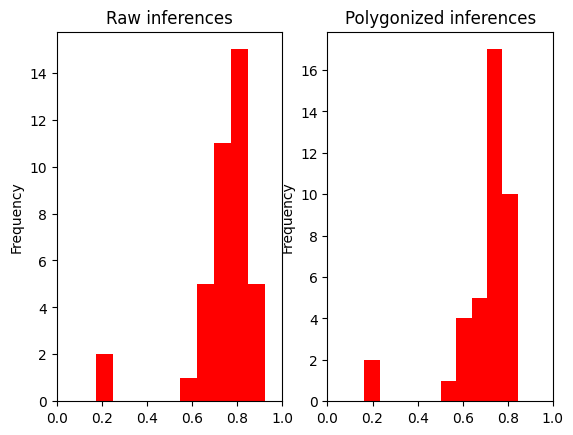

Epsilon: 0.7
count    39.000000
mean      0.739984
std       0.148413
min       0.171594
25%       0.721789
50%       0.774017
75%       0.804528
max       0.922504
Name: IoU, dtype: float64
count    39.000000
mean      0.703591
std       0.142110
min       0.166913
25%       0.686975
50%       0.739755
75%       0.771656
max       0.840209
Name: IoU, dtype: float64


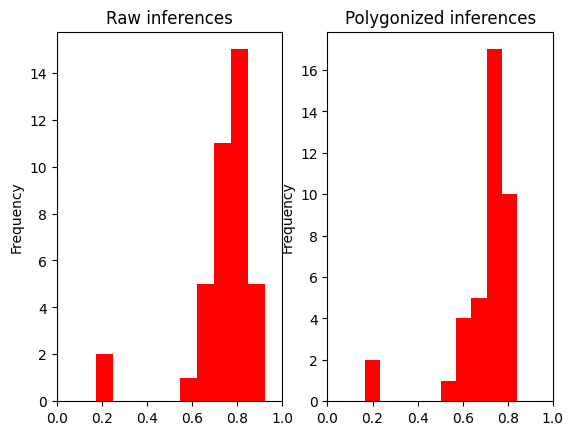

Epsilon: 0.8
count    39.000000
mean      0.739984
std       0.148413
min       0.171594
25%       0.721789
50%       0.774017
75%       0.804528
max       0.922504
Name: IoU, dtype: float64
count    39.000000
mean      0.702694
std       0.143448
min       0.157587
25%       0.683923
50%       0.736309
75%       0.770004
max       0.853365
Name: IoU, dtype: float64


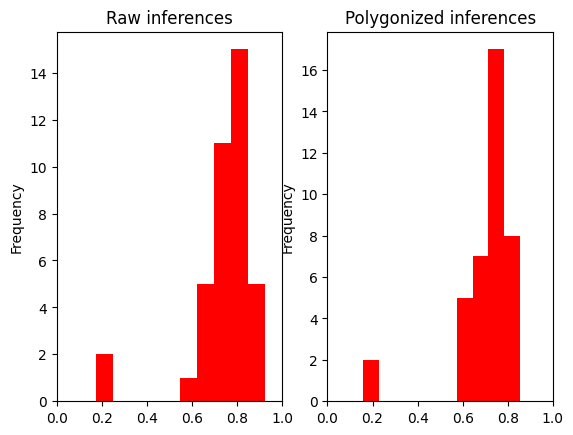

Epsilon: 0.9
count    39.000000
mean      0.739984
std       0.148413
min       0.171594
25%       0.721789
50%       0.774017
75%       0.804528
max       0.922504
Name: IoU, dtype: float64
count    39.000000
mean      0.699707
std       0.143236
min       0.157348
25%       0.681949
50%       0.732005
75%       0.766963
max       0.848128
Name: IoU, dtype: float64


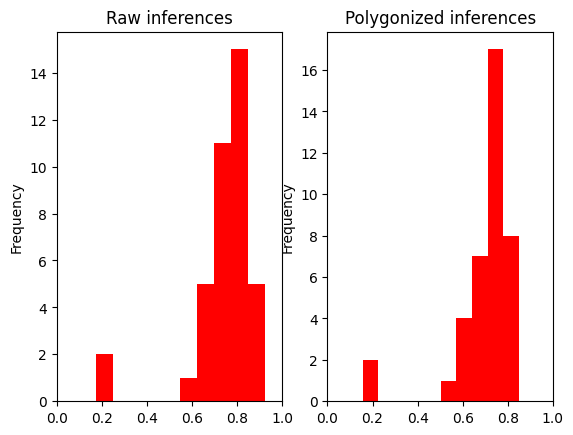

In [43]:
# Compute IoU at the tile level with OSM
for epsilon in epsilon_values:
    print('Epsilon: {}'.format(epsilon))
    tile_all = tile_all_dict[str(epsilon)]

    iou = tile_all[['gdf_type', 'geometry']].copy()

    iou_osm = iou.loc[iou['gdf_type'] == 'osm']
    iou_infer = iou.loc[iou['gdf_type'] == 'infer']
    iou_poly = iou.loc[iou['gdf_type'] == 'poly']
    
    # Get intersection and union between OSM and poly/infer at the building-level
    iou_infer_I = gpd.overlay(iou_osm, iou_infer, how='intersection', keep_geom_type=False)
    iou_infer_U = gpd.overlay(iou_osm, iou_infer, how='union', keep_geom_type=False)

    iou_poly_I = gpd.overlay(iou_osm, iou_poly, how='intersection', keep_geom_type=False)
    iou_poly_U = gpd.overlay(iou_osm, iou_poly, how='union', keep_geom_type=False)

    iou_dict = {'infer_I': iou_infer_I, 'infer_U': iou_infer_U, 'poly_I': iou_poly_I, 'poly_U': iou_poly_U}
    
    # Add tile information
    for key, gdf in iou_dict.items():
        gdf = gdf.sjoin(tiles_gdf, how='left', predicate='intersects')
        iou_dict[key] = gdf

    # Compute I and U areas
    for key, gdf in iou_dict.items():
        gdf = gdf.dissolve(by='file')

        gdf = gdf.to_crs('EPSG:26910')
        gdf['area_{}'.format(key)] = gdf.area
        gdf = gdf.to_crs('EPSG:4326')

        iou_dict[key] = gdf.reset_index()
        
    # Compute I/U
    iou_infer = iou_dict['infer_I'][['file', 'area_infer_I']].merge(
        iou_dict['infer_U'][['file', 'area_infer_U']], how='inner', on='file')

    iou_poly = iou_dict['poly_I'][['file', 'area_poly_I']].merge(
        iou_dict['poly_U'][['file', 'area_poly_U']], how='inner', on='file')
    
    iou_infer['IoU'] = iou_infer['area_infer_I'] / iou_infer['area_infer_U']
    iou_poly['IoU'] = iou_poly['area_poly_I'] / iou_poly['area_poly_U']
    
    print(iou_infer['IoU'].describe())
    print(iou_poly['IoU'].describe())
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True)
    ax1.set_title('Raw inferences')
    iou_infer['IoU'].plot.hist(xlim=(0,1), color='red', ax=ax1)

    ax2.set_title('Polygonized inferences')
    iou_poly['IoU'].plot.hist(xlim=(0, 1), color='red', ax=ax2)
    plt.show()

# Playground

Differing number of polygons

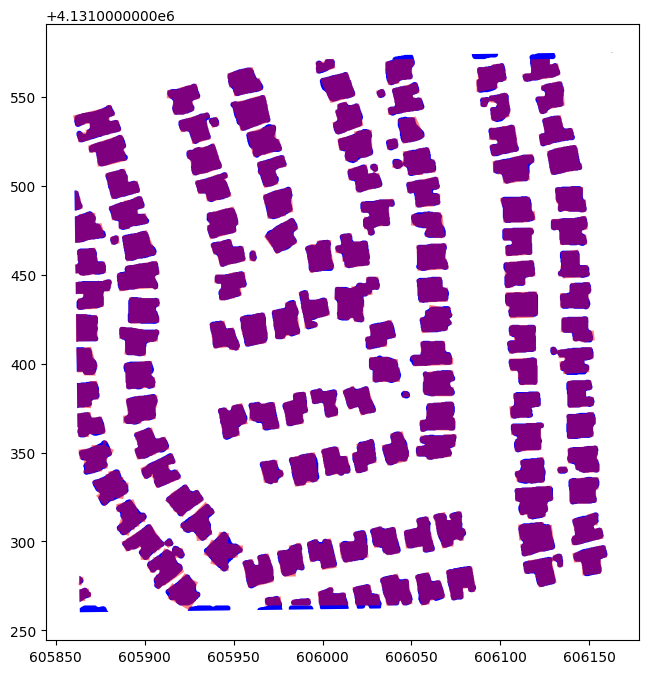

In [145]:
tile_name = random_tile_names[1]
infer_tile, osm_tile, poly_tile, tile_img = polygonize_tile(tile_name=tile_name, verbose=False)
len(poly_tile)
len(infer_tile)
fig, ax = plt.subplots(figsize=(8, 8))
infer_tile.to_crs('EPSG:26910').plot(ax=ax, facecolor='blue', alpha=1)
poly_tile.to_crs('EPSG:26910').plot(ax=ax, facecolor='red', alpha=0.)
plt.show()

Check rasters

In [93]:
# Check rasters
tile_name = 'm_3712141_sw_10_060_20200525_99'
out_file = os.path.join(OUTPUT_FP_POLY, '{}-infer.tif'.format(tile_name))
poly_file = os.path.join(OUTPUT_FP_POLY, '{}-douglas.gpkg'.format(tile_name))
    
tile_bounds = get_bounds(tile_bounds_dict, tile_name)
img_file = os.path.join(IMG_FP, 'train', 'images', '{}.npy'.format(tile_name))
tile_img = np.load(img_file)

# Load inference and OSM
infer_tile = gpd.clip(building_footprints_infer, tile_bounds)
# Polygonize
#run_tile(epsilon=0.5, input_fn=out_file, output_fn=poly_file, verbose=True)

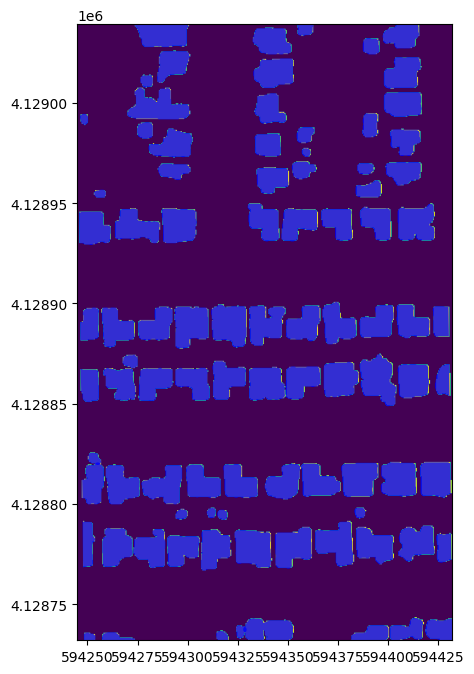

In [95]:
# Read in 
src = rasterio.open(out_file)
raster_generated = src.read(1)

# Check
fig, ax = plt.subplots(figsize=(8, 8))
rasterio.plot.show(raster_generated,transform=src.transform, ax=ax)
infer_tile.to_crs('EPSG:26910').plot(ax=ax, facecolor='blue', alpha=0.8)
plt.show()

In [69]:
input_fn=out_file
output_fn=poly_file

In [92]:
with rasterio.open(input_fn) as f:
    arr = f.read(1)
    print(arr.sum())

    features = list(
        rasterio.features.dataset_features(
            f,
            bidx=1,
            sampling=1,
            band=True,
            as_mask=False,
            with_nodata=False,
            geographic=False,
            precision=-1,
        )
    )



43350


In [81]:
raster_generated.sum()

43350

In [84]:
features

[]

In [83]:
shapes

[]